In [1]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Empathic library imports
import empathicTD as empTD
import offTD as offTD
from policies import Policy, LeftRightPolicy
from models import Model
from utils import mom

In [2]:
%matplotlib notebook

# Models

The models are made to have all the parameters for all the TD.

In [ ]:
#
# Modele with fives states (1, 2)
#

pi = LeftRightPolicy(n = 5, p_right = 1)

mu = LeftRightPolicy(n = 5, p_left = 2/3)

model = Model(features = [[1, 0, 0],
                          [1, 1, 0],
                          [0, 1, 0],
                          [0, 1, 1],
                          [0, 0, 1]],
              R = np.ones(5),
              pi = pi, mu = mu,
              v_pi = [4, 3, 2, 1, 1],
              discounts = [0, 1, 1, 1, 0],
              lambdas = np.zeros(5),
              theta0 = 0, 
              alpha = 0.001,
              I = np.ones(5),
              S0 = 2)  

# Two states model

## Définition

In [3]:
#
# Modele with two states (1, 2)
#

pi = LeftRightPolicy(n = 2, p_right = 1)

mu = LeftRightPolicy(n = 2) # Uniform is default
    
model = Model(features = [1, 2], R = [0,0],
              pi = pi, mu = mu,
              I = [1, 0], discounts = [0.9, 0.9],
              lambdas = [0, 0],
              theta0 = 1,
              alpha = 0.001,
              S0 = 0)  

## Paper results

In [ ]:
T = 5000
N = 200

theta_emp = empTD.run(model, T, N)  
theta_neu = offTD.run(model, T, N)    

theta_neu_opt = offTD.optimal_run(model, T)
theta_emp_opt = empTD.optimal_run(model, T) 

theta_emp_mom = mom(np.swapaxes(theta_emp, 0, 1))
theta_neu_mom = mom(np.swapaxes(theta_neu, 0, 1))

In [ ]:
i = 0
plt.title("EmpathicTD and offTD with {} particles".format(N))

plt.plot(theta_emp[:, : , i].squeeze(), linewidth = 0.2, c = "blue")
plt.plot(theta_emp_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")
plt.plot(theta_emp_opt[:, i], c = "black", linewidth = 3)

plt.plot(theta_neu[:, : , i].squeeze(), linewidth = 0.2, c = "red")
plt.plot(theta_neu_opt[:, i], c = "black", linewidth = 3)
plt.plot(theta_neu_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")

plt.ylim(-3, 3)
plt.xlim(0, T)
plt.show()

## With other rewards

In [8]:
model = Model(features = [[1,0], [0,1]],
              R = [3,10], v_pi = [10/0.1, 10/0.1],
              pi = pi, mu = mu,
              I = [1, 1], discounts = [0.9, 0.9],
              lambdas = [0, 0],
              theta0 = 1,
              alpha = 0.001,
              S0 = 0) 

In [7]:
offTD.optimal(model), empTD.optimal(model)

(array([100., 100.]), array([100., 100.]))

In [5]:
T = 20000
N = 200

theta_emp = empTD.run(model, T, N)  
theta_neu = offTD.run(model, T, N)    

# Deterministic run
theta_neu_opt = offTD.optimal_run(model, T)
theta_emp_opt = empTD.optimal_run(model, T) 

# Compute the MOM estimator for theta (remove the outlier)
theta_emp_mom = mom(np.swapaxes(theta_emp, 0, 1))
theta_neu_mom = mom(np.swapaxes(theta_neu, 0, 1))

In [47]:
i = 0
plt.plot(theta_emp[:, : , i].squeeze(), linewidth = 0.2, c = "blue")
plt.plot(theta_emp_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")
plt.plot(theta_emp_opt[:, i], c = "black", linewidth = 3)

<IPython.core.display.Javascript object>


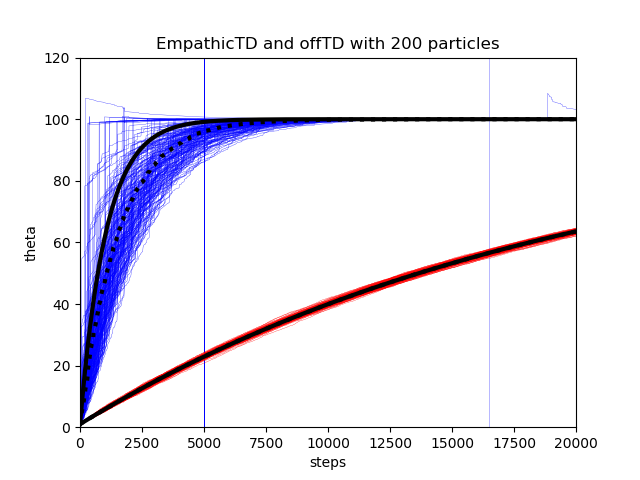

In [6]:
i = 1
plt.figure()
plt.title("EmpathicTD and offTD with {} particles".format(N))

plt.plot(theta_emp[:, : , i].squeeze(), linewidth = 0.2, c = "blue")
plt.plot(theta_emp_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")
plt.plot(theta_emp_opt[:, i], c = "black", linewidth = 3)

plt.plot(theta_neu[:, : , i].squeeze(), linewidth = 0.2, c = "red")
plt.plot(theta_neu_opt[:, i], c = "black", linewidth = 3)
plt.plot(theta_neu_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")

plt.ylim(0, 120)
plt.ylabel("theta")
plt.xlabel("steps")
plt.xlim(0, T)
plt.show()

In [34]:
plt.axhline(y=93, color='r', linestyle='-')

In [11]:
plt.plot(model.msve(theta_emp_opt), linewidth = 6, c = "black", linestyle = "dotted")
plt.plot(model.msve(theta_neu_opt), linewidth = 6, c = "black", linestyle = "dotted")

<IPython.core.display.Javascript object>


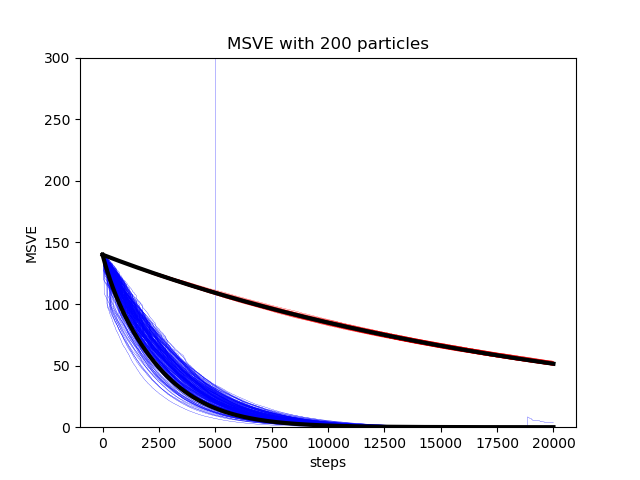

In [14]:
plt.figure()
plt.title("MSVE with {} particles".format(N))

plt.plot(model.parallel_msve(theta_emp), linewidth = 0.2, c = "blue")
plt.plot(model.parallel_msve(theta_neu), linewidth = 0.2, c = "red")

plt.plot(model.msve(theta_emp_opt), c = "black", linewidth = 3)
plt.plot(model.msve(theta_neu_opt), c = "black", linewidth = 3)

plt.ylim(0, 300)
plt.ylabel("MSVE")
plt.xlabel("steps")
plt.show()

In [38]:
theta_emp[T]

array([[    99.98397449,     99.99999789],
       [    99.9845097 ,     99.99996776],
       [   107.23928439,    101.17646835],
       [    99.97747491,     99.99998514],
       [    99.97838901,     99.99797568],
       [    99.9492147 ,     99.99795596],
       [    99.97934115,     99.99950214],
       [    99.98053122,    100.0001377 ],
       [    99.99166485,     99.99995826],
       [    99.9881514 ,     99.9999717 ],
       [    99.97210644,     99.99917237],
       [    99.96943052,     99.99903899],
       [    99.99074648,    100.00000243],
       [    99.97779135,     99.999506  ],
       [    99.98719427,    100.00000105],
       [    99.99056677,     99.99999828],
       [    99.98522981,     99.99974898],
       [    99.98962753,    100.00000042],
       [    99.97040226,     99.99983513],
       [    99.96989135,     99.99923153],
       [    99.96805141,     99.99972996],
       [    99.98485451,    100.00499349],
       [    99.98426247,     99.99998811],
       [   

# Five states model